# Pre-Requisit

## Installs

In [24]:
%pip install keras
%pip install tensorflow
%pip install matplotlib
%pip install scikit-learn
%pip install pillow
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Imports


In [25]:
import os
import keras
import random
import shutil
import numpy as np
import seaborn as sns
import tensorflow as tf

from os import path
from keras import layers
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, RandomBrightness, RandomRotation, RandomZoom, RandomContrast
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix


## Loading the data

In [27]:
all_labels = ['NORMAL', 'PNEUMONIA']
# TODO: change it
base_dir = "/Users/neriya.shulman/content/chest_xray"
img_size = 250


In [28]:
def load_data(base_dir, img_size, all_labels):
    dataset = []
    labels = []
    file_names = []
    for dir_ in os.scandir(base_dir):
        if not dir_.is_dir():
            continue
        label = all_labels.index(dir_.name)
        for file in os.scandir(dir_.path):
            if file.name == '.DS_Store':
                continue
            img = load_img(file.path, target_size=(img_size, img_size), color_mode='grayscale')
            arr_img = img_to_array(img)
            dataset.append(arr_img)
            labels.append(label) # change label to 0 or 1
            file_names.append(file.name)
    dataset = np.array(dataset, dtype='float32')
    labels = np.expand_dims(labels, -1)
    file_names = np.expand_dims(file_names, -1)
    return dataset, labels, file_names

In [29]:
orig_train_set, orig_train_labels, train_file_names = load_data(path.join(base_dir, "train"), img_size, all_labels)
orig_validation_set, orig_validation_labels, _ = load_data(path.join(base_dir, "val"), img_size, all_labels)
test_set, test_labels, _ = load_data(path.join(base_dir, "test"), img_size, all_labels)

## Data preprocessing

Normalization

In [30]:
orig_train_set /= 255
orig_validation_set /= 255
test_set /= 255

Increase validation set

In [31]:
print('validation set size before moving from the train: ', len(orig_validation_set))

num_to_move = 200
normal_indexes = [i for i, label in enumerate(orig_train_labels.reshape(-1)) if label == 0]
bacteria_indexes = [i for i, file in enumerate(train_file_names.reshape(-1)) if 'bacteria' in file]
virus_indexes = [i for i, file in enumerate(train_file_names.reshape(-1)) if 'virus' in file]

new_indexes = np.concatenate((normal_indexes[:num_to_move], bacteria_indexes[:num_to_move//2], virus_indexes[:num_to_move//2]), axis=0)
validation_set = np.concatenate((orig_validation_set, orig_train_set[new_indexes]), axis=0)
validation_labels = np.concatenate((orig_validation_labels, orig_train_labels[new_indexes]), axis=0)

train_set = np.delete(orig_train_set, new_indexes, axis=0)
train_labels = np.delete(orig_train_labels, new_indexes, axis=0)

print('validation set size after moving: ', len(validation_set))


validation set size before moving from the train:  16
validation set size after moving:  416


Balance the training data

Number of images in training set:  4816
Number of Normal images:  1141
Number of Pneumonia images:  3675
Ratio between classes: 24:76


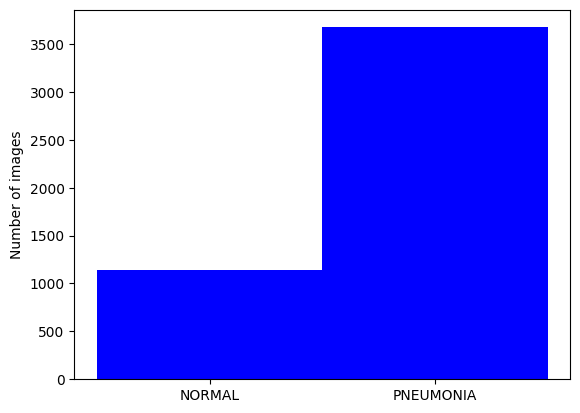

In [32]:
normal_train_data = train_set[train_labels[:, 0] == 0] 
pneum_train_data = train_set[train_labels[:, 0] == 1]

print('Number of images in training set: ', len(train_set))
print('Number of Normal images: ', len(normal_train_data))
print('Number of Pneumonia images: ', len(pneum_train_data))
print(f'Ratio between classes: {round(len(normal_train_data)/len(train_set)*100)}:{round(len(pneum_train_data)/len(train_set)*100)}')

plt.hist(train_labels, bins=2, color='blue')
plt.ylabel('Number of images')
plt.xticks([0.25, 0.75], ['NORMAL', 'PNEUMONIA'])
plt.show()

Balance the data by multiplying the normal images

In [33]:
multiply_by = round(len(pneum_train_data) / len(normal_train_data))
normal_train_data = np.concatenate([normal_train_data for _ in range(multiply_by)], axis=0)
normal_train_labels = np.full((len(normal_train_data), 1), all_labels.index('NORMAL'))
pneum_train_labels = np.full((len(pneum_train_data), 1), all_labels.index('PNEUMONIA'))

train_set = np.concatenate([normal_train_data, pneum_train_data], axis=0)
train_labels = np.concatenate([normal_train_labels, pneum_train_labels], axis=0)



Number of Normal images:  3423
Number of Pneumonia images:  3675
Ratio between classes: 48:52


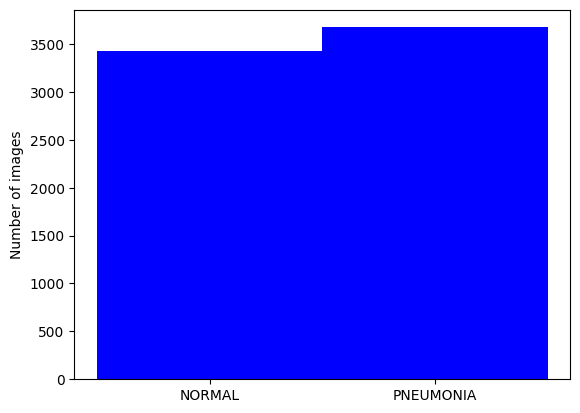

In [34]:
print('Number of Normal images: ', len(normal_train_data))
print('Number of Pneumonia images: ', len(pneum_train_data))
print(f'Ratio between classes: {round(len(normal_train_data)/len(train_set)*100)}:{round(len(pneum_train_data)/len(train_set)*100)}')
plt.hist(train_labels.squeeze(), bins=2, color='blue')
plt.ylabel('Number of images')
plt.xticks([0.25, 0.75], ['NORMAL', 'PNEUMONIA'])
plt.show()

Shuffling

In [35]:
def shuffle_dataset(dataset, labels):
    indices = np.arange(dataset.shape[0])
    np.random.shuffle(indices)
    return dataset[indices], labels[indices]

train_set, train_labels = shuffle_dataset(train_set, train_labels)

## The model

In [36]:
max_epochs = 50
batch_size = 64
learning_rate=0.001

In [37]:


model = keras.Sequential(
    [
        keras.Input(shape=(img_size, img_size, 1)),
        RandomRotation(0.35),
        RandomZoom(0.1),
        RandomBrightness(0.15, value_range=(0,1)),
        RandomContrast(0.1),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name='flatten'),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        layers.Dropout(0.5),
        Dense(units=32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=1, activation='sigmoid'),
    ]
)

model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy", "recall", "precision"])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(train_set, train_labels, epochs=max_epochs, batch_size=batch_size,
        validation_data=(validation_set, validation_labels), callbacks=[early_stopping])


Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.5691 - loss: 0.7860 - precision: 0.6098 - recall: 0.4509 - val_accuracy: 0.7019 - val_loss: 0.5974 - val_precision: 0.6288 - val_recall: 0.9856
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.7945 - loss: 0.4801 - precision: 0.8030 - recall: 0.8070 - val_accuracy: 0.9207 - val_loss: 0.2072 - val_precision: 0.9534 - val_recall: 0.8846
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.8764 - loss: 0.3368 - precision: 0.8934 - recall: 0.8640 - val_accuracy: 0.8750 - val_loss: 0.2880 - val_precision: 0.9875 - val_recall: 0.7596
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.8914 - loss: 0.3032 - precision: 0.9141 - recall: 0.8720 - val_accuracy: 0.9375 - val_loss: 0.1767 - val_precision: 0.9691 - val_recall: 0.9038
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.8917 - loss: 0.3078 - precision: 0.9107 - recall: 0.8765 - val_accuracy: 0.8990 - va

In [38]:
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_1               │ (None, 250, 250, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 250, 250, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_1             │ (None, 250, 250, 1)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 250, 250, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 248, 248, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 238144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    30,482,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,535,237 (349.18 MB)

 Trainable params: 30,511,745 (116.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,023,492 (232.79 MB)

None


Show the metrics of the model

In [39]:
score = model.evaluate(test_set, test_labels, batch_size=batch_size)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test recall:", score[2])
print("Test precision:", score[3])


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9160 - loss: 0.2421 - precision: 0.9770 - recall: 0.9199
Test loss: 0.35937631130218506
Test accuracy: 0.9006410241127014
Test recall: 0.9153845906257629
Test precision: 0.924870491027832


In [40]:
score = model.evaluate(test_set, test_labels, batch_size=batch_size)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test recall:", score[2])
print("Test precision:", score[3])


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9160 - loss: 0.2421 - precision: 0.9770 - recall: 0.9199
Test loss: 0.35937631130218506
Test accuracy: 0.9006410241127014
Test recall: 0.9153845906257629
Test precision: 0.924870491027832


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


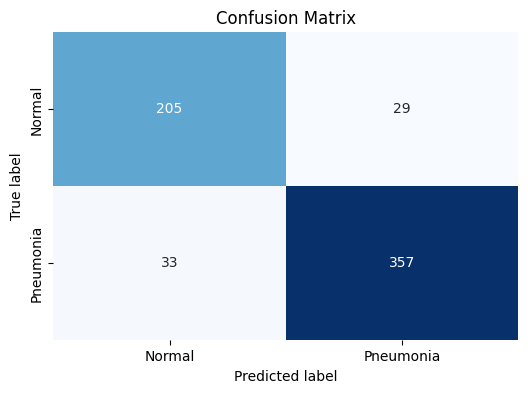

In [41]:

result = model.predict(test_set)
pred_test_labels = np.where(result > 0.5, 1, 0)
conf_matrix = confusion_matrix(test_labels.squeeze(), pred_test_labels.squeeze())

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

save the model

In [42]:
model.save('model_q1_a.keras')